<a href="https://colab.research.google.com/github/hwansoo1981/ai/blob/master/Project03_Renewable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import scipy.stats as st
import itertools

In [0]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')

# For Google Drive
# df_re = pd.read_csv("https://drive.google.com/uc?export=download&id=1doPUKoTn5ADNBAb6fJfmOyEpAbnmeVHV", parse_dates=[['date', 'time']])

# For Github
df_re = pd.read_csv("https://raw.githubusercontent.com/tgjeon/kings/master/data-03-renewable.csv", parse_dates=[['date', 'time']])


In [0]:
print(df_re.shape)
print(df_re.nunique())

(83768, 4)
date_time      83768
windspeed       8554
activepower    47471
pressure          13
dtype: int64


In [0]:
print(df_re.info())

# Pressure data from "https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83768 entries, 0 to 83767
Data columns (total 4 columns):
date_time      83768 non-null datetime64[ns]
windspeed      83768 non-null float64
activepower    83768 non-null float64
pressure       83768 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.6 MB
None


In [0]:
df_re.head()

,date_time,windspeed,activepower,pressure
0,2011-08-04 00:00:00,4.525,163.782,1004.3
1,2011-08-04 00:00:01,4.735,164.871,1004.3
2,2011-08-04 00:00:02,4.931,167.839,1004.3
3,2011-08-04 00:00:03,5.152,169.065,1004.3
4,2011-08-04 00:00:04,5.206,167.709,1004.3


Text(0.5, 1.0, 'Time series data for power generation')

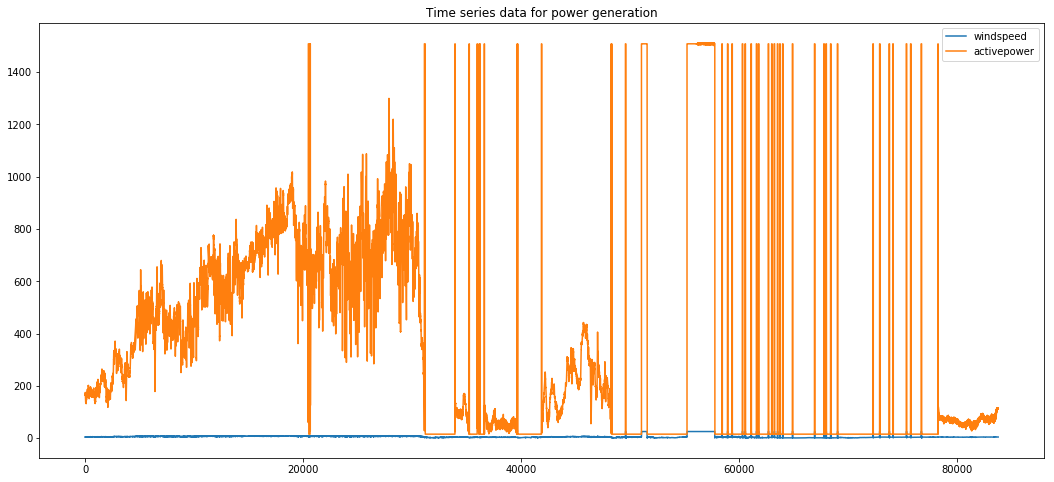

In [0]:
plt.figure(figsize=(18,8))
plt.plot(df_re['windspeed'])
plt.plot(df_re['activepower'])

plt.legend()
plt.title('Time series data for power generation')

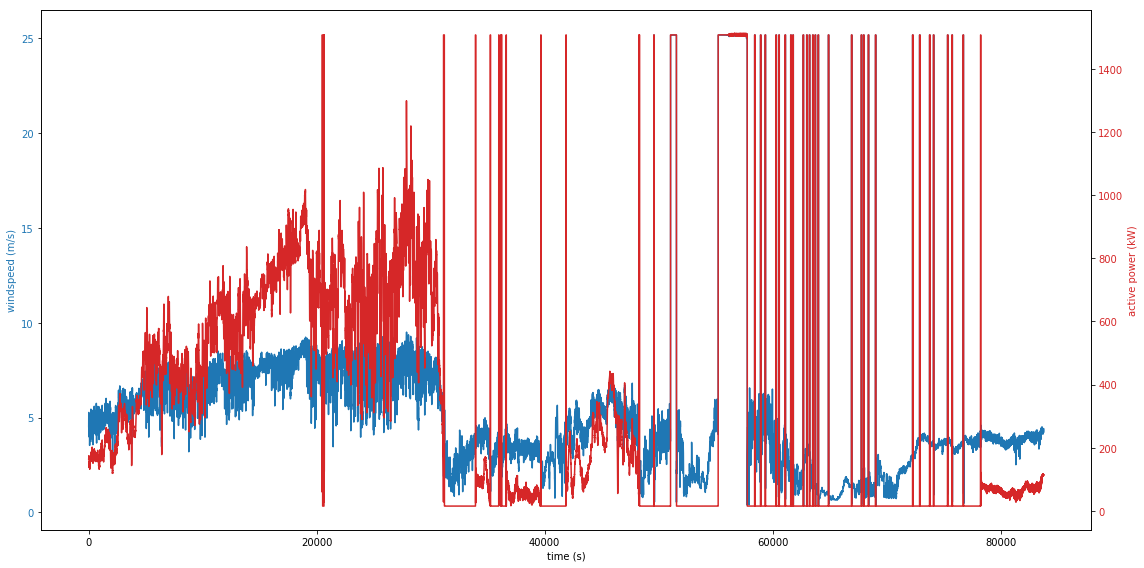

In [0]:
fig, ax1 = plt.subplots(figsize=(16,8))

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('windspeed (m/s)', color=color)
ax1.plot(df_re['windspeed'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('active power (kW)', color=color)  # we already handled the x-label with ax1
ax2.plot(df_re['activepower'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

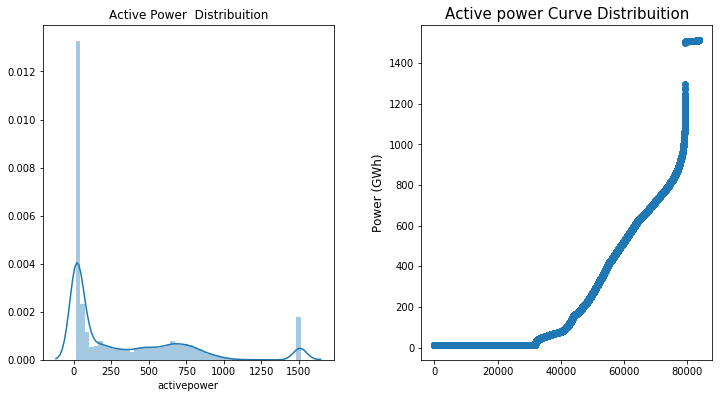

In [0]:
plt.figure(figsize = (12, 6))

plt.subplot(121)
plt.title('Active Power  Distribuition')
sns.distplot(df_re['activepower'])

plt.subplot(122)
g1 = plt.scatter(range(df_re.shape[0]), np.sort(df_re.activepower.values))
g1 = plt.title("Active power Curve Distribuition", fontsize=15)
g1 = plt.xlabel("")
g1 = plt.ylabel("Power (GWh)", fontsize=12)

plt.subplots_adjust(wspace = 0.3, hspace = 0.5,
                    top = 0.9)
plt.show()


In [0]:
print("ActivePower Min")
print(df_re['activepower'].min())
print("ActivePower Mean")
print(df_re['activepower'].mean())
print("ActivePower Median")
print(df_re['activepower'].median())
print("ActivePower Max")
print(df_re['activepower'].max())
print("ActivePower Std")
print(df_re['activepower'].std())

ActivePower Min
14.855
ActivePower Mean
326.2784439404106
ActivePower Median
101.922
ActivePower Max
1512.28
ActivePower Std
404.1197821404361


<Figure size 576x360 with 0 Axes>

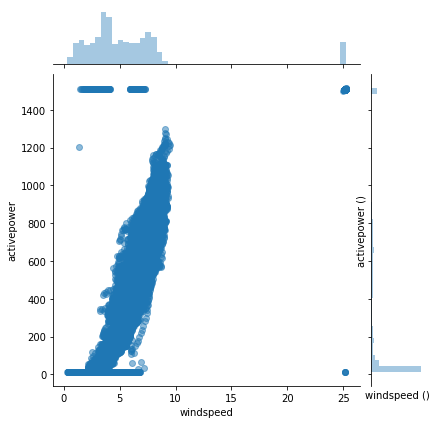

In [0]:
plt.figure(figsize = (8, 5))
sns.jointplot(df_re.windspeed, df_re.activepower, 
              alpha = 0.5)
plt.xlabel('windspeed ()')
plt.ylabel('activepower ()')
plt.show()

# Correlation Matrix

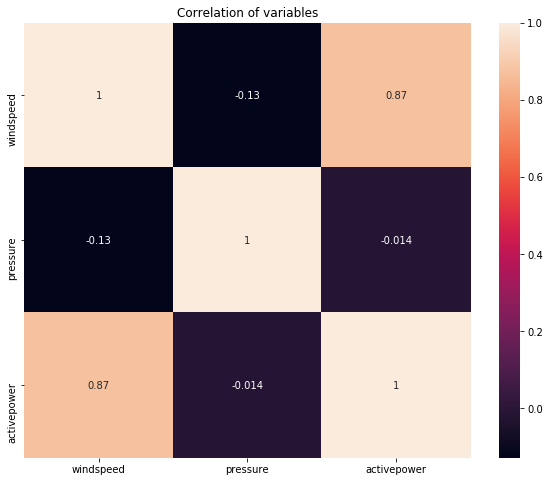

In [0]:
corr = df_re[['windspeed','pressure','activepower']]

plt.figure(figsize=(10,8))
plt.title('Correlation of variables')
sns.heatmap(corr.astype(float).corr(),vmax=1.0,  annot=True)
plt.show()

In [0]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import explained_variance_score, median_absolute_error, r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

In [0]:
########################################################
######## IMPORTING NECESSARY MODULES AND MODELS ########
########################################################

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit # Model evaluation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler # Preprocessing
from sklearn.linear_model import Lasso, Ridge, ElasticNet, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge # Linear models
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  # Ensemble methods
from xgboost import XGBRegressor, plot_importance # XGBoost
from sklearn.svm import SVR, SVC, LinearSVC  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline # Streaming pipelines
from sklearn.decomposition import KernelPCA, PCA # Dimensionality reduction
from sklearn.feature_selection import SelectFromModel # Dimensionality reduction
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV # Model evaluation
from sklearn.base import clone # Clone estimator
from sklearn.metrics import mean_squared_error as MSE

In [0]:
# X = df_re.drop("activepower" ,axis=1).values
X = df_re[["windspeed","pressure"]].values
y = df_re["activepower"].values

num_samples = df_re.shape[0]
window_size = 12 
num_splits = num_samples - window_size

tscv = TimeSeriesSplit(max_train_size=None, n_splits=window_size)
for train_index, test_index in tscv.split(X):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

TRAIN: [   0    1    2 ... 6449 6450 6451] TEST: [ 6452  6453  6454 ... 12892 12893 12894]
TRAIN: [    0     1     2 ... 12892 12893 12894] TEST: [12895 12896 12897 ... 19335 19336 19337]
TRAIN: [    0     1     2 ... 19335 19336 19337] TEST: [19338 19339 19340 ... 25778 25779 25780]
TRAIN: [    0     1     2 ... 25778 25779 25780] TEST: [25781 25782 25783 ... 32221 32222 32223]
TRAIN: [    0     1     2 ... 32221 32222 32223] TEST: [32224 32225 32226 ... 38664 38665 38666]
TRAIN: [    0     1     2 ... 38664 38665 38666] TEST: [38667 38668 38669 ... 45107 45108 45109]
TRAIN: [    0     1     2 ... 45107 45108 45109] TEST: [45110 45111 45112 ... 51550 51551 51552]
TRAIN: [    0     1     2 ... 51550 51551 51552] TEST: [51553 51554 51555 ... 57993 57994 57995]
TRAIN: [    0     1     2 ... 57993 57994 57995] TEST: [57996 57997 57998 ... 64436 64437 64438]
TRAIN: [    0     1     2 ... 64436 64437 64438] TEST: [64439 64440 64441 ... 70879 70880 70881]
TRAIN: [    0     1     2 ... 70879 

In [0]:
# X = df_re.drop("activepower" ,axis=1).values
# y = df_re["activepower"].values

# X_train = []
# X_test = []
# y_train = []
# y_test = []

# from sklearn.model_selection import StratifiedShuffleSplit
# SEED = 42
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)

# train, test = sss.split(X, y).next()
# X_train, y_train = X[train], y[train]
# X_test, y_test = X[test], y[test]

In [0]:
print (X_train[13], y_train[13])
print (X_train.shape)

[   5.026 1004.3  ] 173.36700000000002
(77325, 2)


In [0]:
thresh = 5 * 10**(-3)
model = XGBRegressor()
model.fit(X_train, y_train)
#select features using threshold
selection = SelectFromModel(model, threshold=thresh, prefit=True)
select_X_train = selection.transform(X_train)
# eval model
select_X_val = selection.transform(X_test)
# test 
select_X_test = selection.transform(X_test)

[03:56:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
pipelines = []
seed = 2

pipelines.append(
                ("Scaled_Ridge", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Ridge", Ridge(random_state=seed, tol=10 ))
                      ]))
                )
pipelines.append(
                ("Scaled_Lasso", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Lasso", Lasso(random_state=seed, tol=1))
                      ]))
                )
pipelines.append(
                ("Scaled_Elastic", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Lasso", ElasticNet(random_state=seed))
                      ]))
                )

pipelines.append(
                ("Scaled_SVR",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("SVR",  SVR(kernel='linear', C=1e2, degree=5))
                 ])
                )
                )

pipelines.append(
                ("Scaled_RF_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("RF", RandomForestRegressor(random_state=seed))
                 ])
                )
                )

pipelines.append(
                ("Scaled_ET_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("ET", ExtraTreesRegressor(random_state=seed))
                 ])
                )
                )
pipelines.append(
                ("Scaled_BR_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BaggingRegressor(random_state=seed))
                 ]))) 

pipelines.append(
                ("Scaled_Hub-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Hub-Reg", HuberRegressor())
                 ]))) 
pipelines.append(
                ("Scaled_BayRidge",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BayesianRidge())
                 ]))) 

pipelines.append(
                ("Scaled_XGB_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("XGBR", XGBRegressor(seed=seed))
                 ]))) 

pipelines.append(
                ("Scaled_DT_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("DT_reg", DecisionTreeRegressor())
                 ]))) 

pipelines.append(
                ("Scaled_KNN_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("KNN_reg", KNeighborsRegressor())
                 ])))

pipelines.append(
                ("Scaled_Gboost-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("GBoost-Reg", GradientBoostingRegressor())
                 ])))

pipelines.append(
                ("Scaled_RFR_PCA",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("PCA", PCA(n_components=3)),
                     ("XGB", RandomForestRegressor())
                 ])))

pipelines.append(
                ("Scaled_XGBR_PCA",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("PCA", PCA(n_components=3)),
                     ("XGB", XGBRegressor())
                 ])))

In [0]:
#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'r2'
n_folds = 7

results, names  = [], [] 

for name, model  in pipelines:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv= kfold,
                                 scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)

Scaled_Ridge: -0.107997 (+/- 1.193136)
Scaled_Lasso: -0.107983 (+/- 1.196341)
Scaled_Elastic: -0.396931 (+/- 1.585558)


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,15))
fig.suptitle('Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Names of Algorithm", fontsize=20)
ax.set_ylabel("R Squared Score of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

# Testing the best models

In [0]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)

In [0]:
xgb.fit(X_train, y_train)

In [0]:
y_hat = xgb.predict(X_test)
xgb.score(X_test,y_test)

## Randomized Search in RandomForest Regressor


In [0]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

## Using Random Search to find the best Hyper Paramns

In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [0]:
#Knowning the best params
rf_random.best_params_

In [0]:
# Predicting with best params
y_hat_Search = rf_random.predict(X_test)

In [0]:
print("XGBoost Regressor R2-score: {}".format(round(r2_score(y_hat, y_test),4)))
print("RandomForest Regressor Prediction R2-score: {}".format(round(r2_score(y_hat_Search, y_test),4)))
print("\nMSE of XGBoost Regressor: {}".format(median_absolute_error(y_hat, y_test)))
print("MSE of RandomForest Regressor: {} ".format(median_absolute_error(y_hat_Search, y_test)))

### [END_OF_FILE]